Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
[skip] SSP 1-2.6 (3 km): no data
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

ERROR: No data found for your input values. Please modify your data request. 
Returning None
ERROR: No data found for your input values. Please modify your data request. 
Returning None
[skip] SSP 

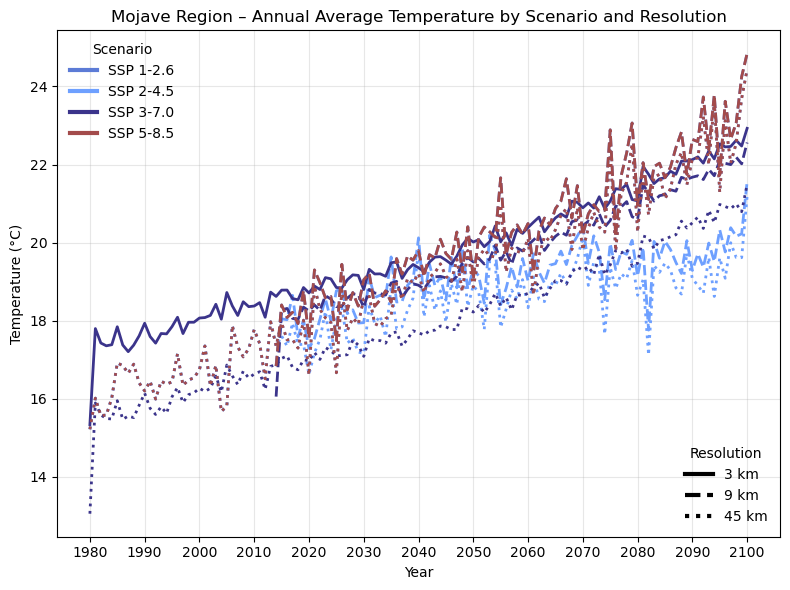

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from climakitae.core.data_interface import get_data

LAT_SLICE = (34.6, 35.8)
LON_SLICE = (-117.4, -115.6)

SCENARIOS = [
    "SSP 1-2.6",
    "SSP 2-4.5",
    "SSP 3-7.0",
    "SSP 5-8.5",
]

COLORS = {
    "Historical Climate": "#8fbbe8",
    "SSP 1-2.6": "#5c7bd6",
    "SSP 2-4.5": "#6ea0ff",
    "SSP 3-7.0": "#3b348b",
    "SSP 5-8.5": "#a34b4b",
}

LINE_STYLES = {
    "3 km": "-",
    "9 km": "--",
    "45 km": ":",
}

def ensure_celsius(da: xr.DataArray) -> xr.DataArray:
    if da.attrs.get("units", "").lower().startswith("k"):
        da = da - 273.15
        da.attrs["units"] = "°C"
    return da

def fetch_box(variable: str, scenario: str):
    for method, res in [("Statistical", "3 km"), ("Dynamical", "3 km")]:
        try:
            ds = get_data(
                variable=variable,
                downscaling_method=method,
                resolution=res,
                timescale="monthly",
                scenario=scenario,
                time_slice=(1980, 2100),
                latitude=LAT_SLICE,
                longitude=LON_SLICE,
            )
        except (KeyError, ValueError):
            continue
        if ds is None or getattr(ds, "time", None) is None or ds.time.size == 0:
            continue
        da = ds[list(ds.data_vars)[0]] if isinstance(ds, xr.Dataset) else ds
        spatial_dims = [d for d in da.dims if d not in ("time", "scenario", "simulation", "member", "realization")]
        if spatial_dims:
            da = da.mean(dim=spatial_dims)
        return ensure_celsius(da)
    return None

annual_data = {}

for scen in SCENARIOS:
    annual_data[scen] = {}
    for res in ["3 km", "9 km", "45 km"]:
        if res == "3 km":
            da = fetch_box("Air Temperature at 2m", scen)
        else:
            try:
                ds = get_data(
                    variable="Air Temperature at 2m",
                    downscaling_method="Dynamical",
                    resolution=res,
                    timescale="monthly",
                    scenario=scen,
                    time_slice=(1980, 2100),
                    latitude=LAT_SLICE,
                    longitude=LON_SLICE,
                )
            except Exception as e:
                ds = None
            if ds is None or getattr(ds, "time", None) is None or ds.time.size == 0:
                da = None
            else:
                da = ds[list(ds.data_vars)[0]] if isinstance(ds, xr.Dataset) else ds
                spatial_dims = [d for d in da.dims if d not in ("time", "scenario", "simulation", "member", "realization")]
                if spatial_dims:
                    da = da.mean(dim=spatial_dims)
                da = ensure_celsius(da)

        if da is None or getattr(da, "time", None) is None or da.time.size == 0:
            print(f"[skip] {scen} ({res}): no data")
            continue

        ens_dims = [d for d in da.dims if d in ("simulation", "member", "realization")]
        if ens_dims:
            da = da.mean(dim=ens_dims)

        annual_means = da.groupby("time.year").mean("time")

        extra_dims = [d for d in annual_means.dims if d != "year"]
        if extra_dims:
            annual_means = annual_means.mean(dim=extra_dims)

        years = annual_means["year"].values
        temp_values = annual_means.values

        annual_data[scen][res] = (years, temp_values)

fig, ax = plt.subplots(figsize=(8, 6))

for scen in SCENARIOS:
    if scen not in annual_data:
        continue
    for res, (years, temps) in annual_data[scen].items():
        ax.plot(
            years, temps,
            color=COLORS.get(scen, None),
            linestyle=LINE_STYLES.get(res, "-"),
            linewidth=2.0,
        )

ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Mojave Region – Annual Average Temperature by Scenario and Resolution")
ax.grid(alpha=0.3)

all_years = []
for scen in annual_data:
    for years, vals in annual_data[scen].values():
        if len(years) > 0:
            all_years.extend(list(years))

if all_years:
    start_year = int(np.min(all_years))
    end_year = int(np.max(all_years))
    ax.set_xticks(np.arange(start_year, end_year + 1, 10))

scenario_handles = [plt.Line2D([0], [0], color=COLORS[scen], linewidth=3, linestyle="-") for scen in SCENARIOS]
scenario_labels = SCENARIOS
res_handles = [plt.Line2D([0], [0], color="black", linewidth=3, linestyle=LINE_STYLES[res]) for res in ["3 km", "9 km", "45 km"]]
res_labels = ["3 km", "9 km", "45 km"]

legend1 = ax.legend(handles=scenario_handles, labels=scenario_labels, title="Scenario",
                    loc="upper left", frameon=False)
legend2 = ax.legend(handles=res_handles, labels=res_labels, title="Resolution",
                    loc="lower right", frameon=False)
ax.add_artist(legend1)

plt.tight_layout()
plt.show()